In [1]:
import matplotlib.pyplot as plt
import skimage.filters
import skimage.io
import keras
import numpy
import cv2
import os

In [2]:
# Load input and output imgs

input_dirs = [
    r"D:\DELFT\Q4 GEO1101 Synthesis\ML\solar_panels\qgis_export\run4\rgb_pairs\19\A",
]
output_dirs = [
    r"D:\DELFT\Q4 GEO1101 Synthesis\ML\solar_panels\qgis_export\run4\rgb_pairs\19\B",
]
output_shape = (246, 246, 1)

def crop_img(img, shape):
    x_diff = (img.shape[0] - shape[0]) // 2
    y_diff = (img.shape[1] - shape[1]) // 2
    crop_img = img[ 
        x_diff : x_diff + shape[0],
        y_diff : y_diff + shape[1],
    ]
    return crop_img

def bw_img(img):
    bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bw_img = bw_img.reshape(*bw_img.shape, 1)
    return bw_img

def load_images(dirs, crop=None, BW=False):
    imgs = []

    for dir in dirs:
        for sub in os.walk(dir):
            subdir = sub[0]
            files = sub[2]
            for file in files:
                filepath = subdir + "\\" + file
                img = skimage.io.imread(filepath)
                if BW:
                    img = bw_img(img)
                if crop:
                    img = crop_img(img, crop)
                img = img / 255.0 # normalize
                imgs.append(img)

    return numpy.array(imgs)


input_imgs = load_images(input_dirs)
input_shape = input_imgs[0].shape
output_imgs = load_images(output_dirs, crop=output_shape, BW=True)
output_shape = output_imgs[0].shape

print(input_shape, output_shape)
print(len(input_imgs))


(256, 256, 3) (246, 246, 1)
1814


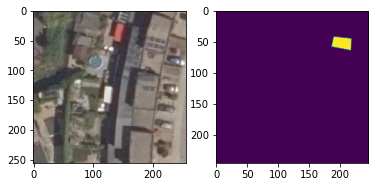

In [3]:
# Show the first pair in the dataset

f, axarr = plt.subplots(1,2) 
axarr[0].imshow(input_imgs[0])
axarr[1].imshow(output_imgs[0].reshape(*output_shape[:2]))

In [4]:
# Create a simple CNN model

from keras.models import Sequential
from keras import layers

model = keras.Sequential(
    [
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu", input_shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(1, kernel_size=(3, 3), activation="sigmoid")
    ]
)

In [6]:
from datetime import datetime
%load_ext tensorboard

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 16784), started 1 day, 15:10:03 ago. (Use '!kill 16784' to kill it.)

In [7]:
# Compile model and start training

batch_size = 4
epochs = 200

model.compile(optimizer="adam", loss="binary_crossentropy")
model.fit(
    input_imgs, 
    output_imgs, 
    batch_size=batch_size, 
    epochs=epochs,
    verbose=True,
    callbacks=[tensorboard_callback]
)


Epoch 1/200
454/454 [==============================] - 39s 41ms/step - loss: 0.1782
Epoch 2/200
454/454 [==============================] - 18s 39ms/step - loss: 0.1137
Epoch 3/200
454/454 [==============================] - 18s 39ms/step - loss: 0.1020
Epoch 4/200
454/454 [==============================] - 18s 40ms/step - loss: 0.0929
Epoch 5/200
454/454 [==============================] - 18s 40ms/step - loss: 0.0983
Epoch 6/200
454/454 [==============================] - 18s 40ms/step - loss: 0.0961
Epoch 7/200
454/454 [==============================] - 18s 40ms/step - loss: 0.0962
Epoch 8/200
454/454 [==============================] - 18s 40ms/step - loss: 0.0929
Epoch 9/200
454/454 [==============================] - 18s 40ms/step - loss: 0.0879
Epoch 10/200
454/454 [==============================] - 18s 40ms/step - loss: 0.0858
Epoch 11/200
454/454 [==============================] - 18s 40ms/step - loss: 0.0759
Epoch 12/200
454/454 [==============================] - 18s 40ms/step - lo

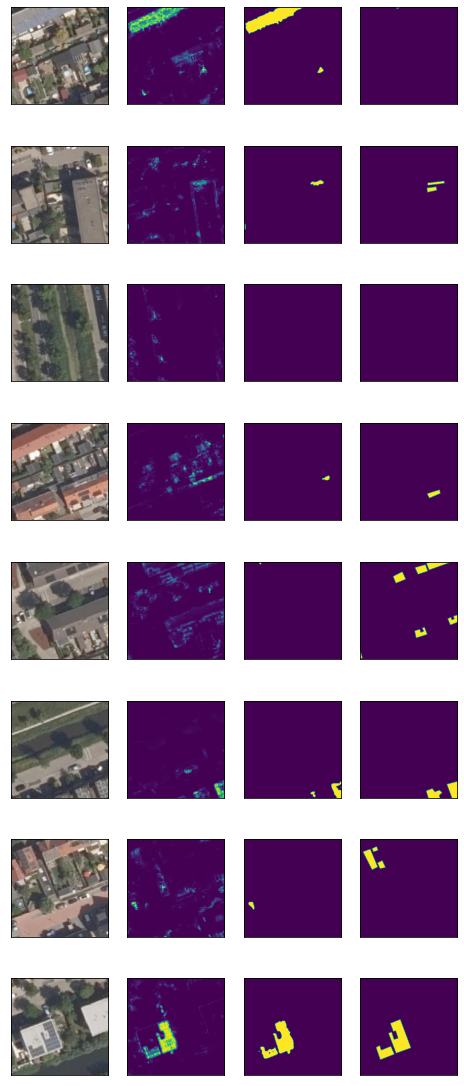

In [12]:
# Infer a result
image_indexes = [10,20,30,40,50,60,70,80]

def hide_axis(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def process_inference(img):
    sigma = 5
    mask = skimage.filters.gaussian(img, sigma=sigma)
    mask = mask > 0.3
    mask = skimage.filters.gaussian(mask, sigma=sigma)
    mask = mask > 0.02
    result = (img * mask) > 0.3
    result = skimage.filters.gaussian(result, sigma=sigma/3)
    result = result > 0.45
    return result

# Plotting
fig, axs = plt.subplots(len(image_indexes), 4)
fig.set_size_inches(8,20)

for i, index in enumerate(image_indexes):
    inp = input_imgs[index].reshape(1, 256, 256, 3)
    infer = model.predict(inp).reshape(246, 246)

    axs[i,0].imshow(input_imgs[index])
    axs[i,1].imshow(infer)
    axs[i,2].imshow(process_inference(infer))
    axs[i,3].imshow(output_imgs[index].reshape(246, 246))

    for ax in axs.flat:
        hide_axis(ax)

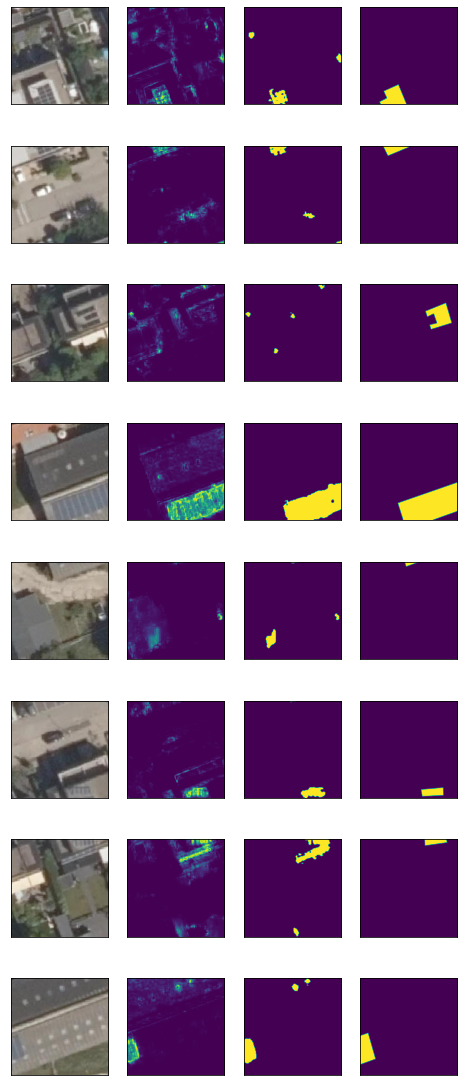

In [13]:
test_input_dirs = [
    r"D:\DELFT\Q4 GEO1101 Synthesis\ML\solar_panels\qgis_export\run3\rgb_pairs\20\test\A",
]
test_output_dirs = [
    r"D:\DELFT\Q4 GEO1101 Synthesis\ML\solar_panels\qgis_export\run3\rgb_pairs\20\test\B",
]

test_input_imgs = load_images(test_input_dirs)
test_output_imgs = load_images(test_output_dirs, crop=output_shape, BW=True)

# Infer a result
image_indexes = [i for i,_ in enumerate(test_input_imgs)]

# Plotting
fig, axs = plt.subplots(len(image_indexes), 4)
fig.set_size_inches(8,20)

for i, index in enumerate(image_indexes):
    inp = test_input_imgs[index].reshape(1, 256, 256, 3)
    infer = model.predict(inp).reshape(246, 246)

    axs[i,0].imshow(test_input_imgs[index])
    axs[i,1].imshow(infer)
    axs[i,2].imshow(process_inference(infer))
    axs[i,3].imshow(test_output_imgs[index].reshape(246, 246))

    for ax in axs.flat:
        hide_axis(ax)

In [8]:
model.save(r"D:\DELFT\Q4 GEO1101 Synthesis\ML\keras\models\run4_rgb_19_512-to-256")

INFO:tensorflow:Assets written to: D:\DELFT\Q4 GEO1101 Synthesis\ML\keras\models\run4_rgb_19_512-to-256\assets


In [5]:
model = keras.models.load_model(r"D:\DELFT\Q4 GEO1101 Synthesis\ML\keras\models\run3_rgb_1")